In [42]:
import pyodbc
import pandas as pd

server='DEREK-PC\DEV2016'
db= 'Temp'
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + server + ';DATABASE=' + db + ';Trusted_Connection=yes')

sqlStr = '''
with CTE as (
SELECT [Symbol],b.Year,  b.WeekOfYear
      ,avg([Adj Close] ) as AvgPrice      
  FROM [Temp].[dbo].[UsStocks] a
  join [BIDev].[dbo].[DimDate] b
  on a.Date = b.Date
  where b.Month between 9 and 12
  and WeekOfYear between 38 and 52
  and Year != 2019
  --and Symbol = 'FSB'
  group by b.Year, [Symbol], b.WeekOfYear
)

--select Symbol, Year, [38],[39],[40],[41],[42],[43],[44]
--,[45],[46],[47],[48],[49],[50],[51],[52]
--from CTE
--pivot (
--avg(AvgPrice) for WeekOfYear in (
--[36], [37],[38],[39],[40],[41],[42],[43],[44]
--,[45],[46],[47],[48],[49],[50],[51],[52],[53]
--)
--) Pvt

select * from CTE
order by Symbol, Year, 3

'''

df1 = pd.io.sql.read_sql(sqlStr, conn)
df1.head(1)

,Symbol,Year,WeekOfYear,AvgPrice
0,A,2006,38,19.918


In [57]:
df2 = pd.pivot_table(df1, index = ['Symbol', 'Year'],
                    values = 'AvgPrice',
                    columns = 'WeekOfYear').reset_index()

In [58]:
df2 = df2.dropna(axis = 0, how = 'any')

In [59]:
WeekOfYearColumns = [col for col in df2.columns if col not in ['Symbol','Year']]
df2[WeekOfYearColumns] = df2[WeekOfYearColumns].div(df2['38'], axis = 0)

In [62]:
df2 = df2.dropna(axis = 0, how = 'any')
df2.reset_index(drop=True, inplace=True)
df2.head()

WeekOfYear,Symbol,Year,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
0,A,2006,1.0,1.018576,1.018677,1.045085,1.079626,1.088764,1.101416,1.120394,1.112562,1.108545,1.063159,1.092479,1.118285,1.123607,1.147706
1,A,2007,1.0,0.998350,1.007589,1.023839,1.033408,0.992906,0.981605,0.950507,0.932855,0.989029,1.011961,1.025159,1.001650,0.974264,1.010579
2,A,2008,1.0,0.989474,0.927875,0.783723,0.757212,0.693762,0.679727,0.731579,0.664717,0.571930,0.598075,0.563060,0.569493,0.523294,0.500244
3,A,2009,1.0,0.993676,0.962054,0.958302,0.966663,0.942866,0.896345,0.898060,0.968593,1.032372,1.029853,1.038697,1.043199,1.046307,1.063351
4,A,2010,1.0,1.049236,1.106062,1.114576,1.149349,1.165248,1.173454,1.195507,1.206996,1.208021,1.217176,1.220433,1.274182,1.324033,1.378859


In [63]:
array = df2[WeekOfYearColumns].values
array[:5,]

array([[1.        , 1.01857616, 1.01867657, 1.04508485, 1.07962647,
        1.08876393, 1.1014158 , 1.12039361, 1.1125615 , 1.10854503,
        1.06315895, 1.09247916, 1.11828497, 1.12360679, 1.14770559],
       [1.        , 0.99835024, 1.00758888, 1.02383898, 1.03340757,
        0.99290605, 0.98160521, 0.9505073 , 0.9328549 , 0.98902912,
        1.01196074, 1.02515879, 1.00164976, 0.9742638 , 1.01057906],
       [1.        , 0.98947368, 0.92787524, 0.7837232 , 0.75721248,
        0.69376218, 0.6797271 , 0.73157895, 0.66471735, 0.57192982,
        0.59807505, 0.56306043, 0.56949318, 0.52329435, 0.50024366],
       [1.        , 0.99367564, 0.96205381, 0.95830207, 0.96666309,
        0.94286633, 0.89634473, 0.89805981, 0.96859256, 1.03237217,
        1.02985315, 1.03869654, 1.04319863, 1.04630721, 1.06335084],
       [1.        , 1.04923582, 1.10606216, 1.11457585, 1.14934865,
        1.16524772, 1.17345369, 1.19550723, 1.20699559, 1.20802134,
        1.21717612, 1.22043286, 1.27418197, 

In [64]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
st = time.time()
connectivity = kneighbors_graph(array, n_neighbors=10, include_self=False)
print("Compute unstructured hierarchical clustering...")

ward = AgglomerativeClustering(n_clusters=12, connectivity=connectivity, linkage='ward').fit(array)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)


Compute unstructured hierarchical clustering...
Elapsed time: 20.28s
Number of points: 45541


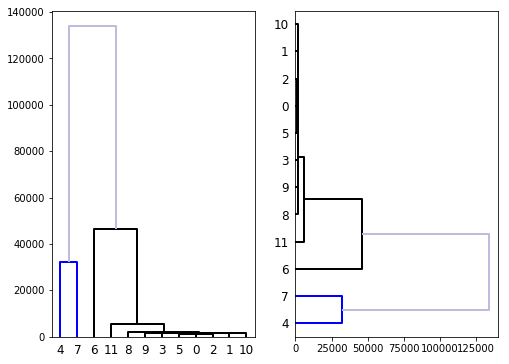

In [65]:
df2['clusters'] = label
df2_Grouped = df2.groupby(['clusters'])
df3 = df2_Grouped.mean()
nparray1 = df3.values

from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['lines.linewidth'] = 2 #Force to change line width

Z = hierarchy.linkage(nparray1, 'single')
#plt.figure()
#dn = hierarchy.dendrogram(Z)

hierarchy.set_link_color_palette(['b', 'k', 'g', 'r'])
fig, axes = plt.subplots(1, 2, figsize=(8, 6),facecolor='white')
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='#bcbddc',
                           orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1], above_threshold_color='#bcbddc',
                           orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

In [67]:
df3.round(2)

WeekOfYear,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
clusters,,,,,,,,,,,,,,,
0,1.0,1.26,95.88,137.50,173.17,182.21,181.10,167.93,170.76,209.78,266.29,342.47,494.57,472.19,416.25
1,1.0,1.00,1.40,1.60,1.20,1.00,1.00,465.00,504.20,1032.00,1046.12,1001.60,1052.30,1074.30,1078.50
2,1.0,1.00,1.00,0.99,1.00,0.99,0.99,1.00,1.00,0.99,1.00,1.01,1.00,1.00,1.01
3,1.0,0.96,0.93,0.89,0.98,0.99,1.11,1148.91,1011.09,0.98,1206.17,1.00,1011.01,0.98,0.91
4,1.0,6.57,1.25,6.71,0.75,17.96,6.58,0.80,6.48,0.88,0.78,36905.19,72023.98,94345.21,94866.02
5,1.0,1.01,1.00,1.03,1.02,0.99,0.97,879.44,800.97,0.90,0.86,0.89,0.88,0.85,0.80
6,1.0,6663.32,33313.15,34053.42,0.63,0.63,1.61,1.61,1.26,1.26,1.73,1.76,1.88,1.68,1.68
7,1.0,1.20,1.20,2.76,3.00,1.64,1.40,1.80,2.40,2.40,1.95,20370.84,81481.56,80000.12,73148.25
8,1.0,1.46,1.69,1.23,1.00,1.00,1.23,1.46,1.00,1.23,1.06,1.23,0.77,0.77,2046.29


In [68]:
df2.groupby('clusters').count()

WeekOfYear,Symbol,Year,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
clusters,,,,,,,,,,,,,,,,,
0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,45526,45526,45526,45526,45526,45526,45526,45526,45526,45526,45526,45526,45526,45526,45526,45526,45526
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### It turns out that all of the clusters are outliers except cluster 2

In [71]:
df2_new = df2[df2['clusters']==2]
df2_new.reset_index(inplace=True, drop= True)

In [72]:
array = df2_new[WeekOfYearColumns].values
array[:5,]

array([[1.        , 1.01857616, 1.01867657, 1.04508485, 1.07962647,
        1.08876393, 1.1014158 , 1.12039361, 1.1125615 , 1.10854503,
        1.06315895, 1.09247916, 1.11828497, 1.12360679, 1.14770559],
       [1.        , 0.99835024, 1.00758888, 1.02383898, 1.03340757,
        0.99290605, 0.98160521, 0.9505073 , 0.9328549 , 0.98902912,
        1.01196074, 1.02515879, 1.00164976, 0.9742638 , 1.01057906],
       [1.        , 0.98947368, 0.92787524, 0.7837232 , 0.75721248,
        0.69376218, 0.6797271 , 0.73157895, 0.66471735, 0.57192982,
        0.59807505, 0.56306043, 0.56949318, 0.52329435, 0.50024366],
       [1.        , 0.99367564, 0.96205381, 0.95830207, 0.96666309,
        0.94286633, 0.89634473, 0.89805981, 0.96859256, 1.03237217,
        1.02985315, 1.03869654, 1.04319863, 1.04630721, 1.06335084],
       [1.        , 1.04923582, 1.10606216, 1.11457585, 1.14934865,
        1.16524772, 1.17345369, 1.19550723, 1.20699559, 1.20802134,
        1.21717612, 1.22043286, 1.27418197, 

In [73]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
st = time.time()
connectivity = kneighbors_graph(array, n_neighbors=10, include_self=False)
print("Compute unstructured hierarchical clustering...")

ward = AgglomerativeClustering(n_clusters=12, connectivity=connectivity, linkage='ward').fit(array)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)


Compute unstructured hierarchical clustering...
Elapsed time: 21.54s
Number of points: 45526


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


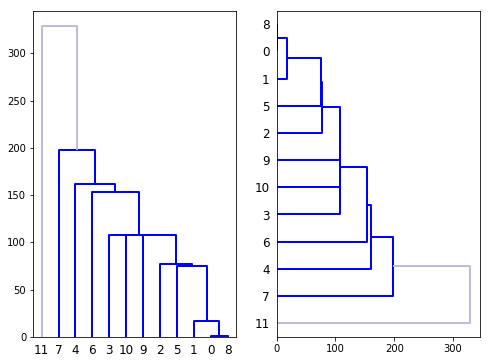

In [75]:
df2_new['clusters'] = label
df2_Grouped = df2_new.groupby(['clusters'])
df3 = df2_Grouped.mean()
nparray1 = df3.values

from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['lines.linewidth'] = 2 #Force to change line width

Z = hierarchy.linkage(nparray1, 'single')
#plt.figure()
#dn = hierarchy.dendrogram(Z)

hierarchy.set_link_color_palette(['b', 'k', 'g', 'r'])
fig, axes = plt.subplots(1, 2, figsize=(8, 6),facecolor='white')
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='#bcbddc',
                           orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1], above_threshold_color='#bcbddc',
                           orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

In [76]:
df3

WeekOfYear,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
clusters,,,,,,,,,,,,,,,
0,1.0,0.988209,0.966049,0.937835,0.930344,0.911508,0.900122,0.893673,0.871497,0.854755,0.857546,0.850139,0.843559,0.832055,0.834016
1,1.0,2.461640,2.968878,4.113374,3.793495,5.192160,4.680152,5.084198,5.105953,6.057276,5.987181,8.108993,7.348176,7.276886,6.733355
2,1.0,0.680763,0.939746,1.037044,1.085825,0.863690,0.837530,10.308025,18.752295,41.394440,37.680686,46.703973,16.374443,30.559140,43.011654
3,1.0,25.976989,45.987216,56.202415,51.611222,49.904261,46.862500,46.239773,44.939915,43.970774,43.268466,39.766335,38.869602,41.431818,42.780007
4,1.0,0.509562,0.010286,0.023771,0.274057,0.802667,0.015924,0.015086,0.831695,180.109714,0.010381,0.600533,0.874667,1.482286,1.541619
5,1.0,0.990183,0.977094,31.199100,10.959812,50.856734,41.312711,30.582064,20.604765,0.953472,25.815012,10.873504,0.910318,10.263524,12.524159
6,1.0,89.700000,1.000000,78.000000,39.500000,39.900000,39.600000,76.466667,116.633333,41.200000,51.208333,41.100000,41.700000,40.966667,145.791667
7,1.0,0.997889,108.027441,107.900792,0.916623,0.844327,0.817414,0.831135,114.081794,0.781003,142.385224,0.635884,0.635884,0.770449,0.725594
8,1.0,1.010811,1.023823,1.039232,1.062834,1.075704,1.091234,1.105808,1.123683,1.138838,1.152541,1.165612,1.177433,1.181940,1.199601


In [80]:
df2_new[['clusters','Symbol']].groupby(['clusters']).count()

WeekOfYear,Symbol
clusters,
0,25527
1,45
2,2
3,2
4,1
5,1
6,1
7,1
8,19943


In [79]:
df2_new.columns

Index(['Symbol', 'Year', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', 'clusters'],
      dtype='object', name='WeekOfYear')

In [81]:
df2_new = df2_new[df2_new['clusters'].isin([0,8])]

In [82]:
df2_new.reset_index(inplace=True, drop= True)
array = df2_new[WeekOfYearColumns].values
array[:5,]

array([[1.        , 1.01857616, 1.01867657, 1.04508485, 1.07962647,
        1.08876393, 1.1014158 , 1.12039361, 1.1125615 , 1.10854503,
        1.06315895, 1.09247916, 1.11828497, 1.12360679, 1.14770559],
       [1.        , 0.99835024, 1.00758888, 1.02383898, 1.03340757,
        0.99290605, 0.98160521, 0.9505073 , 0.9328549 , 0.98902912,
        1.01196074, 1.02515879, 1.00164976, 0.9742638 , 1.01057906],
       [1.        , 0.98947368, 0.92787524, 0.7837232 , 0.75721248,
        0.69376218, 0.6797271 , 0.73157895, 0.66471735, 0.57192982,
        0.59807505, 0.56306043, 0.56949318, 0.52329435, 0.50024366],
       [1.        , 0.99367564, 0.96205381, 0.95830207, 0.96666309,
        0.94286633, 0.89634473, 0.89805981, 0.96859256, 1.03237217,
        1.02985315, 1.03869654, 1.04319863, 1.04630721, 1.06335084],
       [1.        , 1.04923582, 1.10606216, 1.11457585, 1.14934865,
        1.16524772, 1.17345369, 1.19550723, 1.20699559, 1.20802134,
        1.21717612, 1.22043286, 1.27418197, 

In [83]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
st = time.time()
connectivity = kneighbors_graph(array, n_neighbors=10, include_self=False)
print("Compute unstructured hierarchical clustering...")

ward = AgglomerativeClustering(n_clusters=12, connectivity=connectivity, linkage='ward').fit(array)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)


Compute unstructured hierarchical clustering...
Elapsed time: 23.28s
Number of points: 45470


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


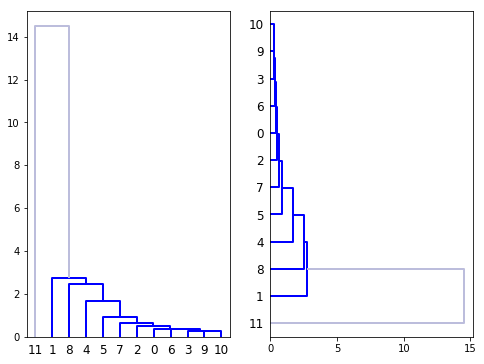

In [84]:
df2_new['clusters'] = label
df2_Grouped = df2_new.groupby(['clusters'])
df3 = df2_Grouped.mean()
nparray1 = df3.values

from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['lines.linewidth'] = 2 #Force to change line width

Z = hierarchy.linkage(nparray1, 'single')
#plt.figure()
#dn = hierarchy.dendrogram(Z)

hierarchy.set_link_color_palette(['b', 'k', 'g', 'r'])
fig, axes = plt.subplots(1, 2, figsize=(8, 6),facecolor='white')
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='#bcbddc',
                           orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1], above_threshold_color='#bcbddc',
                           orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

In [97]:
df3.round(2)

WeekOfYear,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
clusters,,,,,,,,,,,,,,,
0,1.0,1.03,1.06,1.08,1.12,1.13,1.15,1.17,1.21,1.23,1.26,1.28,1.30,1.30,1.33
1,1.0,1.07,1.09,1.14,1.14,1.15,1.20,1.28,1.37,1.54,1.77,2.05,2.69,3.37,3.96
2,1.0,0.98,0.92,0.86,0.84,0.80,0.78,0.77,0.73,0.69,0.69,0.67,0.66,0.65,0.64
3,1.0,1.00,0.99,0.99,0.99,0.99,0.99,0.98,0.97,0.97,0.97,0.96,0.96,0.95,0.96
4,1.0,1.10,1.25,1.39,1.55,1.66,1.80,1.81,1.88,1.99,2.07,2.01,2.02,2.06,2.04
5,1.0,0.96,0.84,0.68,0.63,0.57,0.52,0.52,0.45,0.39,0.39,0.38,0.39,0.39,0.38
6,1.0,0.99,0.97,0.94,0.93,0.91,0.89,0.88,0.86,0.85,0.86,0.85,0.84,0.83,0.83
7,1.0,1.03,1.07,1.10,1.15,1.20,1.25,1.32,1.38,1.43,1.48,1.52,1.56,1.57,1.62
8,1.0,1.27,1.59,1.79,2.02,2.17,2.17,2.43,2.73,2.85,2.81,2.93,2.89,2.83,2.86


In [99]:
df2_new[['clusters','Symbol']].groupby(['clusters']).count()

WeekOfYear,Symbol
clusters,
0,3102
1,45
2,5042
3,12915
4,201
5,1215
6,6355
7,1151
8,57


In [94]:
df2_new_melt = df2_new.melt(id_vars = ['Symbol', 'Year','clusters'], var_name = 'WeekOfYear', value_name = 'RelativePrice')

In [95]:
df2_new_melt.head()

,Symbol,Year,clusters,WeekOfYear,RelativePrice
0,A,2006,10,38,1.0
1,A,2007,3,38,1.0
2,A,2008,2,38,1.0
3,A,2009,3,38,1.0
4,A,2010,0,38,1.0


In [96]:
import os
os.chdir(r'E:\SR\StockLists')
df2_new_melt.to_excel(r'ThanksGiving.xlsx', index=False)

In [102]:
import pandasql as ps

In [127]:
q1 = ''' 
with Incr as (
select Symbol, count(distinct year) as NumYear
from df2_new_melt
where clusters in (0,1,4,7,8,9,10)
group by Symbol
)

, xx as (
select Symbol, count(distinct year) as NumYear
from df2_new_melt
group by Symbol
)

select a.Symbol, a.NumYear
, ifnull(b.NumYear, 0) as IncrYear
, 1.0 * ifnull(b.NumYear, 0) / a.NumYear as PctIncr
from xx a
left join Incr b
on a.Symbol = b.Symbol
'''

df_Rst = ps.sqldf(q1, locals())

In [128]:
df_Rst.head()

,Symbol,NumYear,IncrYear,PctIncr
0,A,13,5,0.384615
1,AA,13,4,0.307692
2,AABA,13,8,0.615385
3,AAC,4,0,0.000000
4,AAL,13,7,0.538462


In [130]:
len(df_Rst)

4820

In [151]:
df_Rst[(df_Rst['PctIncr']> 0.6) & (df_Rst['IncrYear']> 7) & (df_Rst['Symbol'].str.contains('MA'))]

,Symbol,NumYear,IncrYear,PctIncr
613,BMA,13,8,0.615385
2221,IMAX,13,9,0.692308
2661,MA,13,11,0.846154
2669,MANH,13,8,0.615385
2672,MAR,13,8,0.615385
2678,MAT,13,8,0.615385


In [144]:
df2_new[df2_new['Symbol'] == 'AMT'].round(2)

WeekOfYear,Symbol,Year,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,clusters
2322,AMT,2006,1.0,1.01,1.00,1.04,1.04,1.01,1.01,1.03,1.03,1.05,1.04,1.04,1.02,1.02,1.02,9
2323,AMT,2007,1.0,1.04,1.04,1.04,1.03,1.06,1.08,1.06,1.05,1.06,1.08,1.04,1.01,1.00,1.03,9
2324,AMT,2008,1.0,0.97,0.92,0.84,0.86,0.78,0.78,0.83,0.73,0.59,0.69,0.73,0.73,0.74,0.73,2
2325,AMT,2009,1.0,1.02,1.00,1.02,1.07,1.09,1.04,1.06,1.10,1.13,1.13,1.14,1.10,1.15,1.19,10
2326,AMT,2010,1.0,1.04,1.06,1.04,1.04,1.03,1.05,1.07,1.08,1.05,1.06,1.05,1.05,1.02,1.04,9
2327,AMT,2011,1.0,1.00,1.00,1.01,1.03,1.03,1.05,1.06,1.07,1.07,1.04,1.08,1.10,1.09,1.11,9
2328,AMT,2012,1.0,1.00,1.02,1.02,1.06,1.04,1.06,1.05,1.04,1.05,1.06,1.06,1.08,1.09,1.09,9
2329,AMT,2013,1.0,0.99,0.99,0.98,1.03,1.08,1.08,1.06,1.05,1.05,1.05,1.05,1.05,1.04,1.06,9
2330,AMT,2014,1.0,0.99,0.98,0.99,0.98,1.00,1.02,1.03,1.05,1.06,1.09,1.07,1.05,1.03,1.06,9
2331,AMT,2015,1.0,0.99,0.98,1.05,1.05,1.09,1.12,1.13,1.08,1.11,1.11,1.10,1.07,1.07,1.09,10


In [152]:
sqlStr = '''
SELECT [Symbol]
      ,[Name]
      ,[MarketCap]
      ,[Sector]
      ,[industry]
  FROM [Temp].[dbo].[Sectors]
'''

Sec = pd.io.sql.read_sql(sqlStr, conn)
Sec.head(1)

,Symbol,Name,MarketCap,Sector,industry
0,PEGI,Pattern Energy Group Inc.,$2.71B,Public Utilities,Electric Utilities: Central


In [153]:
df_Rst1 = pd.merge(df_Rst, Sec, left_on = 'Symbol', right_on = 'Symbol', how = 'inner')

In [156]:
df_Rst1[(df_Rst1['PctIncr']> 0.6) & (df_Rst1['IncrYear']> 7) ]

,Symbol,NumYear,IncrYear,PctIncr,Name,MarketCap,Sector,industry
2,AABA,13,8,0.615385,Altaba Inc.,$36.47B,Technology,EDP Services
9,AAON,13,9,0.692308,"AAON, Inc.",$2.66B,Capital Goods,Industrial Machinery/Components
10,AAP,13,9,0.692308,Advance Auto Parts Inc,$11.14B,Consumer Services,Other Specialty Stores
20,ABCB,13,8,0.615385,Ameris Bancorp,$2.69B,Finance,Major Banks
25,ABM,13,8,0.615385,ABM Industries Incorporated,$2.42B,Finance,Diversified Commercial Services
28,ABT,13,8,0.615385,Abbott Laboratories,$147.72B,Health Care,Major Pharmaceuticals
36,ACCO,13,8,0.615385,Acco Brands Corporation,$950.66M,Consumer Durables,Publishing
38,ACGL,13,8,0.615385,Arch Capital Group Ltd.,$16.59B,Finance,Property-Casualty Insurers
51,ACN,13,9,0.692308,Accenture plc,$124.33B,Miscellaneous,Business Services
52,ACNB,13,8,0.615385,ACNB Corporation,$247.8M,Finance,Major Banks


In [157]:
sqlStr = '''
SELECT [Symbol], [Close]
  FROM [Temp].[dbo].[UsStocks]
  where Date = '2019-09-18'
  
'''

CurrentPrice = pd.io.sql.read_sql(sqlStr, conn)
CurrentPrice.head(1)

,Symbol,Close
0,ES,83.37


In [158]:
df_Rst2 = pd.merge(df_Rst1, CurrentPrice, left_on = 'Symbol', right_on = 'Symbol', how = 'inner')

In [163]:
df_Rst2[(df_Rst2['PctIncr']> 0.8) & (df_Rst2['IncrYear']> 5) ]

,Symbol,NumYear,IncrYear,PctIncr,Name,MarketCap,Sector,industry,Close
84,AEE,13,11,0.846154,Ameren Corporation,$19.64B,Public Utilities,Power Generation,78.48
180,ALGT,12,10,0.833333,Allegiant Travel Company,$2.47B,Transportation,Air Freight/Delivery Services,152.22
247,AMT,13,11,0.846154,American Tower Corporation (REIT),$97.97B,Consumer Services,Real Estate Investment Trusts,221.61
440,AWK,11,9,0.818182,American Water Works,$22B,Public Utilities,Water Supply,121.52
978,CMS,13,11,0.846154,CMS Energy Corporation,$17.7B,Public Utilities,Power Generation,62.63
1265,DGLD,7,6,0.857143,Credit Suisse AG,$19.17M,Finance,Investment Bankers/Brokers/Service,29.87
1451,EMCI,13,11,0.846154,EMC Insurance Group Inc.,$779.61M,Finance,Property-Casualty Insurers,36.00
2589,LNT,13,11,0.846154,Alliant Energy Corporation,$12.54B,Public Utilities,Power Generation,52.95
2657,MA,13,11,0.846154,Mastercard Incorporated,$280.27B,Miscellaneous,Business Services,275.10
3898,SIX,9,8,0.888889,Six Flags Entertainment Corporation New,$4.61B,Consumer Services,Services-Misc. Amusement & Recreation,54.12
